In [25]:
import tensorflow as tf
import pandas as pd
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'



In [26]:
trainning_df=pd.read_csv('trainning_dataset.csv')
validation_df=pd.read_csv('validation_dataset.csv')
testing_df=pd.read_csv('testing_dataset.csv')

In [27]:
from typing import Any


class Dataframe2ImageDataset:
    @staticmethod
    def load_image(filepath):
        raw = tf.io.read_file(filepath)        
        tensor = tf.io.decode_image(raw)
        tensor = tf.cast(tensor, tf.float32) / 255.0
        return tensor

    def __init__(self,df,path_column,label_column) -> None:
        self.paths=df[path_column].values
        self.labels=np.eye(2)[df[label_column].values]

    def create_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.paths,self.labels))
        dataset = dataset.map(lambda filepath, label: (self.load_image(filepath), label))
        # self.dataset=dataset
        return dataset
    


# trainning_data=Dataframe2ImageDataset(trainning_df,'path','binary_label_code')
# trainning_data.create_dataset()
training_dataset=Dataframe2ImageDataset(trainning_df,'path','binary_label_code').create_dataset()
validation_dataset=Dataframe2ImageDataset(validation_df,'path','binary_label_code').create_dataset()
testing_df_dataset=Dataframe2ImageDataset(testing_df,'path','binary_label_code').create_dataset()



In [28]:
a=iter(training_dataset)
next(a)[0].numpy().shape,next(a)[0].numpy().sum(),next(a)[0].numpy().sum()

((100, 100, 3), 26238.164, 26859.6)

Text(0.5, 1.0, '[1. 0.]')

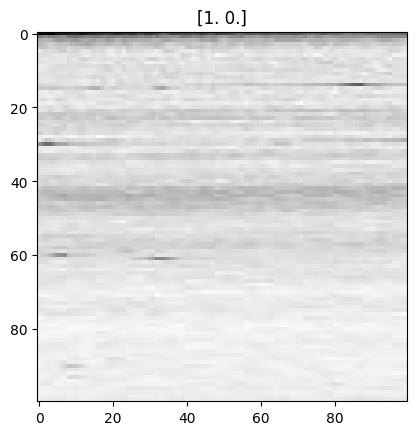

In [29]:
X,Y=next(a)
plt.imshow(X.numpy(),cmap='gray')
plt.title(f'{Y}')

In [30]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='relu',input_shape=(100,100,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=5,strides=1,padding='valid',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='valid',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)])



In [31]:
np.random.seed(1234)

In [32]:
learning_rate=tf.optimizers.schedules.ExponentialDecay(initial_learning_rate=.1,decay_steps=10000.,decay_rate=0.95)
opt=tf.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=tf.metrics.mse,metrics=[tf.metrics.AUC(name='auc')])
# model.summary()

In [33]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
model.fit(training_dataset.batch(10),validation_data=validation_dataset.batch(10),epochs=20,verbose=2,callbacks=[callback,tensorboard_callback])

Epoch 1/20
173/173 - 8s - loss: 0.4592 - auc: 0.5305 - val_loss: 0.4953 - val_auc: 0.5040 - 8s/epoch - 48ms/step
Epoch 2/20
173/173 - 6s - loss: 0.3121 - auc: 0.6712 - val_loss: 0.2466 - val_auc: 0.6758 - 6s/epoch - 34ms/step
Epoch 3/20
173/173 - 7s - loss: 0.2082 - auc: 0.7608 - val_loss: 0.2183 - val_auc: 0.7153 - 7s/epoch - 41ms/step
Epoch 4/20
173/173 - 6s - loss: 0.1790 - auc: 0.8109 - val_loss: 0.2201 - val_auc: 0.7164 - 6s/epoch - 37ms/step
Epoch 5/20
173/173 - 7s - loss: 0.1677 - auc: 0.8335 - val_loss: 0.1937 - val_auc: 0.7932 - 7s/epoch - 41ms/step
Epoch 6/20
173/173 - 7s - loss: 0.1544 - auc: 0.8581 - val_loss: 0.1695 - val_auc: 0.8289 - 7s/epoch - 40ms/step
Epoch 7/20
173/173 - 7s - loss: 0.1433 - auc: 0.8768 - val_loss: 0.1738 - val_auc: 0.8370 - 7s/epoch - 42ms/step
Epoch 8/20
173/173 - 5s - loss: 0.1328 - auc: 0.8926 - val_loss: 0.3226 - val_auc: 0.6561 - 5s/epoch - 28ms/step
Epoch 9/20
173/173 - 6s - loss: 0.1221 - auc: 0.9081 - val_loss: 0.3284 - val_auc: 0.6567 - 6s/e

In [34]:
model.evaluate(testing_df_dataset.batch(32))

 3/12 [======>.......................] - ETA: 0s - loss: 0.2247 - auc: 0.7869

12/12 [==============================] - 1s 64ms/step - loss: 0.2141 - auc: 0.7945


[0.21411164104938507, 0.7944602370262146]